In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import pyabc

import healpy as hp
from astropy.coordinates import SkyCoord
import astropy.units as u

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
import multipoles
from abc_fake_data import model, distance # fake data!
import generate_mocks as gm

### ABC posteriors for Quaia shot noise

In [3]:
nside_hi = 64
resdir = '/scratch/aew492/lss-dipoles_results/results'

base_rate = 33.6330

nmocks = 500
ngens = 15

resdir = os.path.join(resdir, 'ABC/fake_data', f'dipole-0.0_no_excess_base-rate-{base_rate:.4f}_ones_shot-noise-only',
                               f'{nmocks}mocks_{ngens}gens_2025-04-02')

resdict = np.load(os.path.join(resdir, 'results.npy'), allow_pickle=True).item()
data = resdict['data']  # the data as raw quasar counts
selfunc = resdict['selfunc']
observation = resdict['observation']  # the data as overdensity
history = resdict['history']  # History object
prior = resdict['prior']  # dictionary
posterior = resdict['posterior']  # pandas dataframe and weights associated with the final posterior
old_posteriors = resdict['old_posteriors']  # posteriors from the otehr generations

Text(0.5, 0.98, 'Quaia ABC posteriors, shot noise only!, nside=1, 14 generations')

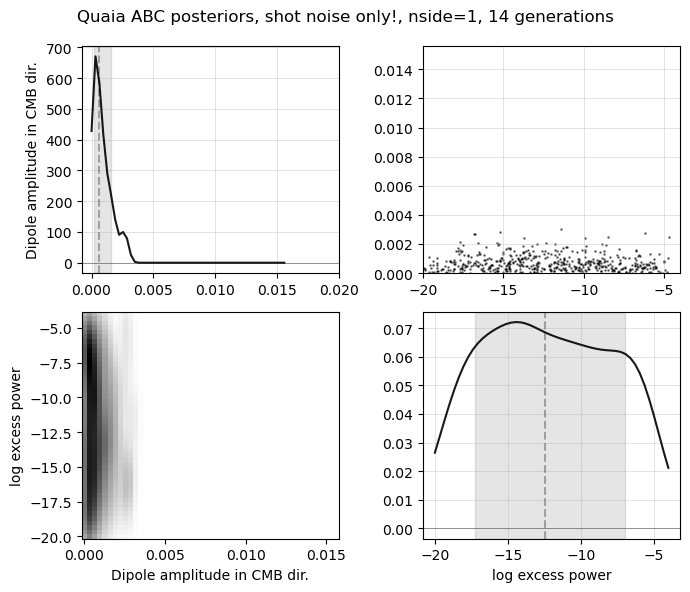

In [4]:
# plot (copied and adjusted from the pyabc.visualization source code)
par_ids = [x for x in prior.keys()]
fig, axs = plt.subplots(len(par_ids), len(par_ids), figsize=(7,6), tight_layout=True)
labels = ['Dipole amplitude in CMB dir.', 'log excess power']

df, w = posterior

for i, par_id in enumerate(par_ids):

    # quantiles?
    q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)

    # diagonal
    ax = axs[i, i]
    x, pdf = tools.get_kde_1d([df, w], prior, par_id)
    ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
    ax.axvline(q[1], c='k', alpha=0.3, ls='--')
    ax.axvspan(q[0], q[2], color='k', alpha=0.1)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
    ax.grid(alpha=0.5, lw=0.5)
    # ax.axvline(data_pars[par_id], c='royalblue', alpha=0.7)

    axs[i,0].set_ylabel(labels[i])
    axs[len(par_ids)-1,i].set_xlabel(labels[i])
    axs[i,0].set_xticks(np.linspace(0., 0.02, 5))

    for j in range(0, i):

        # lower
        ax = axs[i, j]
        x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
        mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')

        # upper
        ax = axs[j, i]
        tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
        ax.grid(alpha=0.5, lw=0.5)
    
fig.suptitle(f'Quaia ABC posteriors, shot noise only!, nside=1, {history.max_t} generations')

Nice to see that we actually recover zero dipole when there is zero dipole!!
But the excess power is _not constrained at all_... what's going on?
I believe, especially thinking through how the model is called, that the `log_excess` parameter does not capture shot noise, but excess power _on top of_ shot noise and the dipole.

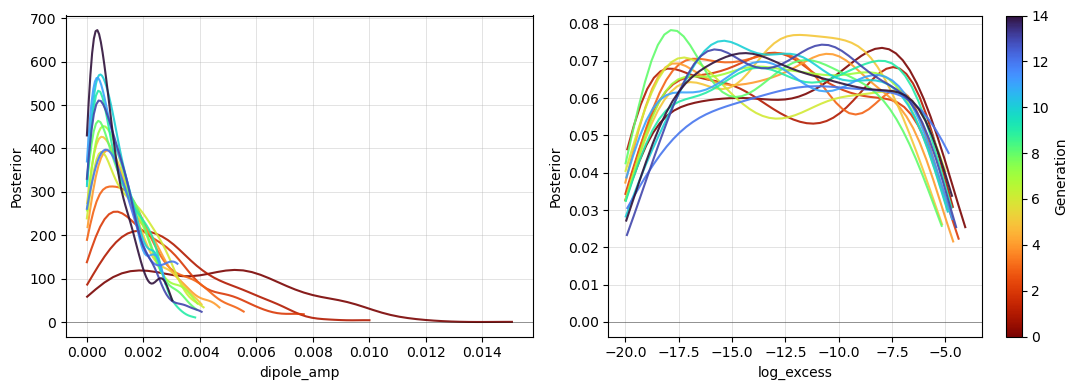

In [22]:
# evolution of the posteriors
fig, axs = plt.subplots(1, 2, figsize=(11,4), tight_layout=True)
norm = mpl.colors.Normalize(vmin=0, vmax=history.max_t)
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo_r')

for j, ax in enumerate(axs):
    for i in range(history.max_t + 1):
        pyabc.visualization.plot_kde_1d_highlevel(history, par_ids[j], t=i, ax=ax, color=smap.to_rgba(i), alpha=0.9)
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel(par_ids[j])
    # ax.set_xlim(prior[par_id][0])
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
fig.colorbar(smap, ax=ax, label='Generation')

### measured $C(\ell)$ from the posterior mocks

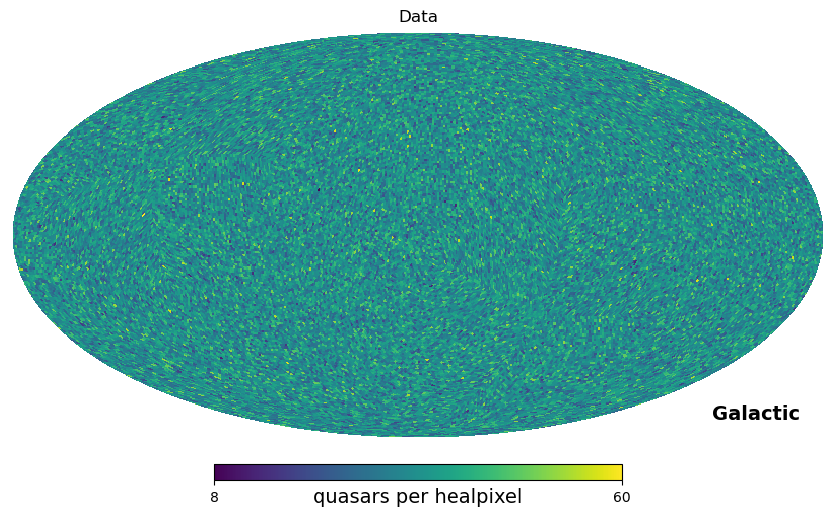

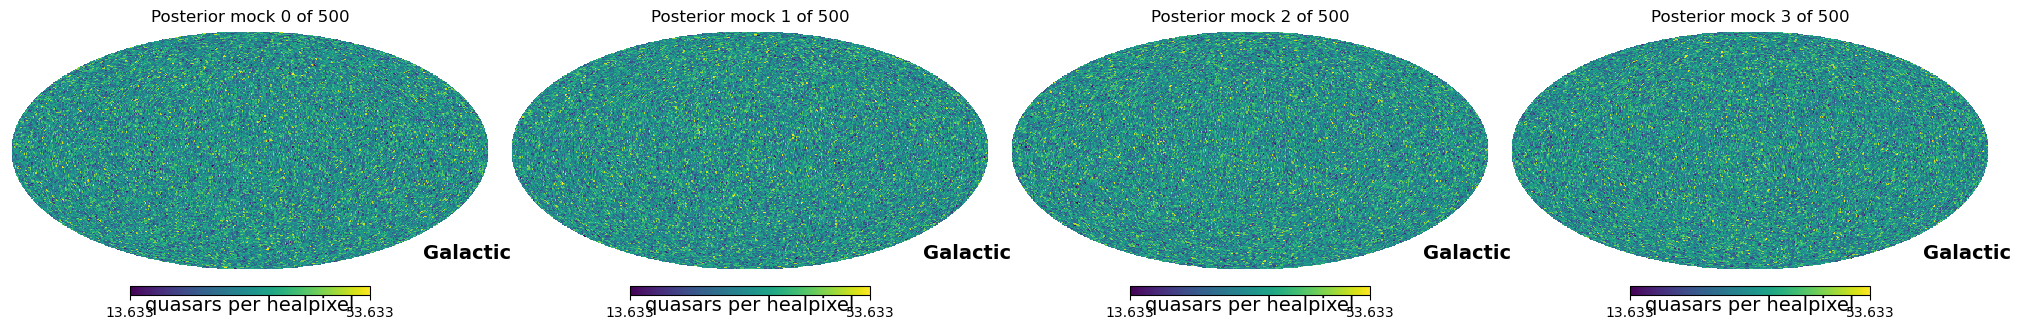

In [7]:
# pull up the "data" and a few example mocks as a sanity check
hp.mollview(data['data'], coord=['C','G'], title='Data', unit='quasars per healpixel')

ntoplot = 4
fig = plt.figure(figsize=((ntoplot + 1) * 4,3))
for i in range(ntoplot):
    mock = np.load(os.path.join(resdir, 'accepted_samples', f'mock{i}.npy'))
    hp.mollview(mock, coord=['C','G'], title=f'Posterior mock {i} of {nmocks}', unit='quasars per healpixel', sub=(1,ntoplot,i+1), fig=fig,
               min=base_rate-20, max=base_rate+20)

In [10]:
np.nanmean(observation)

8.131516293641283e-18

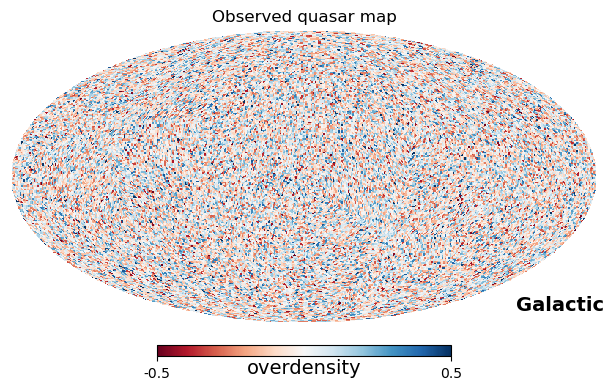

In [12]:
fig = plt.figure(figsize=(12,4))
hp.mollview(observation, coord=['C','G'], unit='overdensity', min=-0.5, max=0.5,
            title='Observed quasar map', cmap='RdBu', sub=(1,2,1), fig=fig)

In [14]:
# compute the Cells in the "data"
ells_data, Cells_data, alms_data = multipoles.compute_Cells_in_overdensity_map_Lambda(observation,
                                                                Lambda=0.,
                                                                max_ell=8, # magic
                                                                selfunc=selfunc,
                                                                return_alms=True)

In [15]:
# load Cells and get mean and std of spectrum
n_ = 500
Cells = []
for i in range(n_):
    res_ = np.load(os.path.join(resdir, 'accepted_samples/Cells', f'Cells_Lambda-0.0_mock{i}.npy'), allow_pickle=True).item()
    Cells.append(res_['Cells'])
mean_Cells = np.nanmean(np.array(Cells), axis=0)
std_Cells = np.nanstd(np.array(Cells), axis=0)

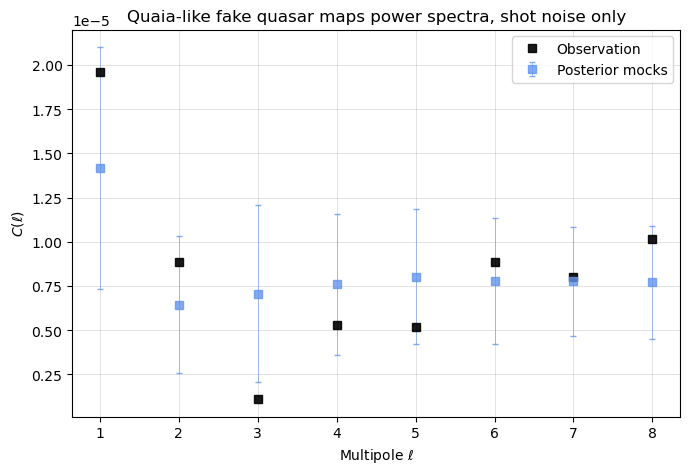

In [20]:
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

ax.errorbar(res_['ells'][1:], mean_Cells[1:], yerr=std_Cells[1:], ls='None', marker='s', capsize=2, lw=0.5,
            c='cornflowerblue', alpha=0.8, label='Posterior mocks')
ax.plot(ells_data[1:], Cells_data[1:], ls='None', marker='s', lw=0.5, c='k', alpha=0.9, label='Observation')
ax.set_xlabel(r'Multipole $\ell$')
ax.set_ylabel(r'$C(\ell)$')
ax.grid(alpha=0.5, lw=0.5)
ax.set_title(f'Quaia-like fake quasar maps power spectra, shot noise only')
ax.legend()

In [21]:
# mean over the ells ?
np.mean(mean_Cells[1:])

8.32161680678681e-06

This matches what we previously found for Quaia, that shot noise was around $\bar C(\ell)\sim 8\times 10^{-6}$.

in earlier run (`500mocks_15gens_2025-03-31`—with narrower `log_excess` prior, from -12 to -2), dipole amplitude was especially low, but in this run (`500mocks_15gens_2025-04-02`), it's especially high... so it must just be stochastic. the exact same model was called with the exact same parameters to generate the "observed" quasar map in both cases